In [156]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pylab as pylab

# Useful plotting thingies:
%matplotlib inline
plt.style.use('ggplot')
pylab.rcParams['figure.figsize'] = 12, 12


In [157]:
def make_slice_volume(l_segs, r_segs, l_D=[], r_D=[]):
    mappings = tb.open_file('/projects/francisco/data/caffe/standardized/data_mappings.h5', 'r')
    l_baseline_mask = mappings.get_node('/l_datamask')[:]
    l_volmask = mappings.get_node('/l_volmask')[:]
    r_baseline_mask = mappings.get_node('/r_datamask')[:]
    r_volmask = mappings.get_node('/r_volmask')[:]
    mappings.close()
    
    l_vols = []
    for HC_input in l_segs:
        flatvol = np.zeros(np.prod(l_volmask.shape))
        flatvol[l_baseline_mask] = HC_input
        l_vols.append(flatvol.reshape(-1, l_volmask.shape[2]).T)

    r_vols = []
    for HC_input in r_segs:
        flatvol = np.zeros(np.prod(r_volmask.shape))
        flatvol[r_baseline_mask] = HC_input
        r_vols.append(flatvol.reshape(-1, r_volmask.shape[2]).T)

    r_vols = np.array(r_vols)
    l_vols = np.array(l_vols)
    
    r_M, r_D = slicify(r_vols, r_D)
    l_M, l_D = slicify(l_vols, l_D)
    return l_M, r_M, l_D, r_D

def slicify(vol, disjoints=[]):
    xmax = vol.shape[2] - 1
    
    if disjoints == []:
        x = 0
        while x < xmax and np.sum(vol[:,:,x]) == 0:
            x += 1
            if np.sum(vol[:,:,x] > 0):
                cur_l = x
                while x < xmax and np.sum(vol[:,:,x]) > 0:
                    x += 1
                if not x == xmax:
                    disjoints.append((cur_l, x))

    M = np.zeros(shape=(vol.shape[0], len(disjoints)))
    
    for u in range(vol.shape[0]):
        for j in range(len(disjoints)):
            l, r = disjoints[j]
            M[u,j] = np.sum(vol[u,:,l:r])

    
    return M, disjoints


In [180]:
import tables as tb
from sklearn.preprocessing import Normalizer, scale

# Set up the experimental matrices:
targets = ['ADAS11_bl', 'ADAS13_bl', 'MMSE_bl']
targets_regex = '|'.join(['^{}$'.format(t) for t in targets])
#modalities = ['CT', 'L_HC', 'R_HC']
modalities = ['CT_', 'L_HC_VOL', 'R_HC_VOL']
modalities_regex = '|'.join(['^{}'.format(m) for m in modalities])

matrices = []
l_D = []
r_D = []
for split in ['train', 'valid', 'test']:
    frame = pd.read_pickle('/projects/francisco/data/ADNI/cli_ct_seg_fused_{}.pkl'.format(split))
    frame = frame[np.isfinite(frame['ADAS11_bl']) & np.isfinite(frame['ADAS13_bl']) & np.isfinite(frame['MMSE_bl'])]
    X_cur = frame.filter(regex=modalities_regex).as_matrix()
    y_cur = frame.filter(regex=targets_regex).as_matrix()
     
    matrices.append((X_cur,y_cur))

var_names = frame.filter(regex=modalities_regex).columns
var_names = list(var_names)

X, y = matrices[0][0], matrices[0][1]
X_v, y_v = matrices[1][0], matrices[1][1]
X_t, y_t = matrices[2][0], matrices[2][1]

# norm = Normalizer()
# X = norm.fit_transform(X)
# X_v = norm.transform(X_v)
# X_t = norm.transform(X_t)
# X = scale(X, with_std=False)
# X_v = scale(X_v, with_std=False)
# X_t = scale(X_t, with_std=False)

print 'Training, Validation, and Testing X, y shapes:'
print X.shape, y.shape
print X_v.shape, y_v.shape
print X_t.shape, y_t.shape

nans = np.sum(np.isnan(y))
print 'Number of delicious nans in y is {}'.format(nans) + ' :(' if nans == 0 else ''

Training, Validation, and Testing X, y shapes:
(483, 76) (483, 3)
(98, 76) (98, 3)
(110, 76) (110, 3)
Number of delicious nans in y is 0 :(


In [181]:
print var_names

['CT_REC.L', 'CT_OLF.L', 'CT_ORBsup.L', 'CT_ORBsupmed.L', 'CT_ORBmid.L', 'CT_ORBinf.L', 'CT_SFGdor.L', 'CT_MFG.L', 'CT_IFGoperc.L', 'CT_IFGtriang.L', 'CT_SFGmed.L', 'CT_SMA.L', 'CT_PCL.L', 'CT_PreCG.L', 'CT_ROL.L', 'CT_PoCG.L', 'CT_SPG.L', 'CT_IPL.L', 'CT_SMG.L', 'CT_ANG.L', 'CT_PCUN.L', 'CT_SOG.L', 'CT_MOG.L', 'CT_IOG.L', 'CT_CAL.L', 'CT_CUN.L', 'CT_LING.L', 'CT_FFG.L', 'CT_HES.L', 'CT_STG.L', 'CT_MTG.L', 'CT_ITG.L', 'CT_TPOsup.L', 'CT_TPOmid.L', 'CT_ACG.L', 'CT_DCG.L', 'CT_PCG.L', 'CT_REC.R', 'CT_OLF.R', 'CT_ORBsup.R', 'CT_ORBsupmed.R', 'CT_ORBmid.R', 'CT_ORBinf.R', 'CT_SFGdor.R', 'CT_MFG.R', 'CT_IFGoperc.R', 'CT_IFGtriang.R', 'CT_SFGmed.R', 'CT_SMA.R', 'CT_PCL.R', 'CT_PreCG.R', 'CT_ROL.R', 'CT_PoCG.R', 'CT_SPG.R', 'CT_IPL.R', 'CT_SMG.R', 'CT_ANG.R', 'CT_PCUN.R', 'CT_SOG.R', 'CT_MOG.R', 'CT_IOG.R', 'CT_CAL.R', 'CT_CUN.R', 'CT_LING.R', 'CT_FFG.R', 'CT_HES.R', 'CT_STG.R', 'CT_MTG.R', 'CT_ITG.R', 'CT_TPOsup.R', 'CT_TPOmid.R', 'CT_ACG.R', 'CT_DCG.R', 'CT_PCG.R', 'L_HC_VOL', 'R_HC_VOL']


In [160]:
def adjusted_r2(y_hat, y, p, n):
    """
    And I quote:
    "adjusted R2 is a comparative measure of suitability of alternative nested sets of explanators"
    """
    r2 = metrics.r2_score(y_hat, y)
    adj_r2 = r2 - (1 - r2) * (p / n - p - 1)
    return r2


In [192]:
from sklearn.linear_model import SGDRegressor, BayesianRidge, RidgeCV
from sklearn.decomposition import RandomizedPCA
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import f_regression
from sklearn import metrics

num_targets = len(targets)
num_models = 3 # Includes dummy model
k_nums = range(1, X.shape[1], 5)
k_nums.append(X.shape[1])
k_classifiers = []
k_selectors = []
stats = np.zeros(shape=(len(k_nums), 3, num_models, num_targets))
for i, k in enumerate(k_nums):
    cur_triple = []
    cur_sel_triple = []
    for t in range(0,len(targets)):
        
        dummy_regressor = DummyRegressor(strategy='mean')
        dsel = SelectKBest(f_regression, k=k)
        
        classifier = RidgeCV(alphas=[0.1, 1.0, 10.0], cv=None, fit_intercept=True, scoring=None, normalize=True)
        sel = RFE(estimator=classifier, n_features_to_select=k, step=0.1)
        
        bayes_classifier = BayesianRidge(compute_score=True, normalize=True)
        bsel = RFE(estimator=bayes_classifier, n_features_to_select=k, step=0.1)
        
        classifiers = [classifier, bayes_classifier, dummy_regressor]
        
        # Feature Selection
        sel.fit(X, y[:,t])
        bsel.fit(X, y[:,t])
        dsel.fit(X, y[:, t])
        
        cur_sel_triple.append((sel, bsel, dsel))
        support = sel.get_support(indices=True)
        bsupport = bsel.get_support(indices=True)
        dsupport = dsel.get_support(indices=True)
        #support = range(k)
        
        # Feature transformation for train set
        X_hat = sel.transform(X)
        X_hatb = bsel.transform(X)
        X_hatd = dsel.transform(X)
        
        # Feature transformation for validation set
        X_hat_v = sel.transform(X_v)
        X_hat_vb = bsel.transform(X_v)
        X_hat_vd = dsel.transform(X_v)

        # Train classifiers on transformed training X
        classifier.fit(X_hat, y[:,t])
        bayes_classifier.fit(X_hatb, y[:,t])
        dummy_regressor.fit(X_hatd, y[:,t])
        
        # Save classifiers for visualizing on later
        cur_triple.append((classifier, bayes_classifier, dummy_regressor))

        # Predict on validation data and log stats
        y_hat_v = classifier.predict(X_hat_v)
        y_hat_vb = bayes_classifier.predict(X_hat_vb)
        y_hat_vd = dummy_regressor.predict(X_hat_vd)
        stats[i,0,0,t] = k
        stats[i,1,0,t] =  metrics.mean_squared_error(y_hat_v, y_v[:,t])
        stats[i,2,0,t] =  adjusted_r2(y_hat_v, y_v[:,t], X_hat.shape[1], X_hat.shape[0])
        stats[i,1,1,t] =  metrics.mean_squared_error(y_hat_vb, y_v[:,t])
        stats[i,2,1,t] =  adjusted_r2(y_hat_vb, y_v[:,t], X_hat_vb.shape[1], X_hat_vb.shape[0])
        stats[i,1,2,t] =  metrics.mean_squared_error(y_hat_vd, y_v[:,t])
        stats[i,2,2,t] =  adjusted_r2(y_hat_vd, y_v[:,t], X_hat_vd.shape[1], X_hat_vd.shape[0])
    k_selectors.append(cur_sel_triple)
    k_classifiers.append(cur_triple)



In [193]:
T = 1 # Current target index

k = stats[:,0,0]
rss = stats[:,1,0]
brss = stats[:,1,1]
drss = stats[:,1,2]
vs = stats[:,2,0]
bvs = stats[:,2,1]
dvs = stats[:,2,2]
stats_table = np.zeros(shape=(len(k_nums), 7, 3))
for i in range(3):
    stats_table[:,:,i] = np.vstack([k[:,i], rss[:,i], brss[:,i], drss[:,i], vs[:,i], bvs[:,i], dvs[:,i]]).T

print 

In [194]:
from tabulate import tabulate
for i in range(3):
    print 'Y: {}'.format(targets[i])
    print tabulate(stats_table[:,:,i], ['K', 'MSE', 'b_MSE', 'd_MSE', 'R2', 'b_R2', 'd_R2'])


Y: ADAS11_bl
  K      MSE    b_MSE    d_MSE         R2      b_R2          d_R2
---  -------  -------  -------  ---------  --------  ------------
  1  35.7616  35.7367  39.5144  -10.264    -8.69718  -3.13066e+30
  6  33.4091  33.267   39.5144   -5.05588  -4.13131  -3.13066e+30
 11  35.4168  35.6603  39.5144   -4.11234  -3.67091  -3.13066e+30
 16  34.5952  34.613   39.5144   -3.54328  -3.41578  -3.13066e+30
 21  34.2086  34.4683  39.5144   -3.42203  -3.4717   -3.13066e+30
 26  34.948   34.4622  39.5144   -3.28497  -3.54006  -3.13066e+30
 31  35.0462  35.1825  39.5144   -3.39059  -3.76218  -3.13066e+30
 36  34.9027  34.9369  39.5144   -3.20275  -3.89131  -3.13066e+30
 41  34.8126  34.4421  39.5144   -3.15274  -3.94459  -3.13066e+30
 46  34.6254  34.5032  39.5144   -3.26766  -4.08196  -3.13066e+30
 51  34.7191  34.6911  39.5144   -3.09325  -4.28697  -3.13066e+30
 56  34.8083  34.5488  39.5144   -6.25074  -4.36104  -3.13066e+30
 61  34.8036  34.5585  39.5144   -6.22427  -4.50648  -3.13066e+

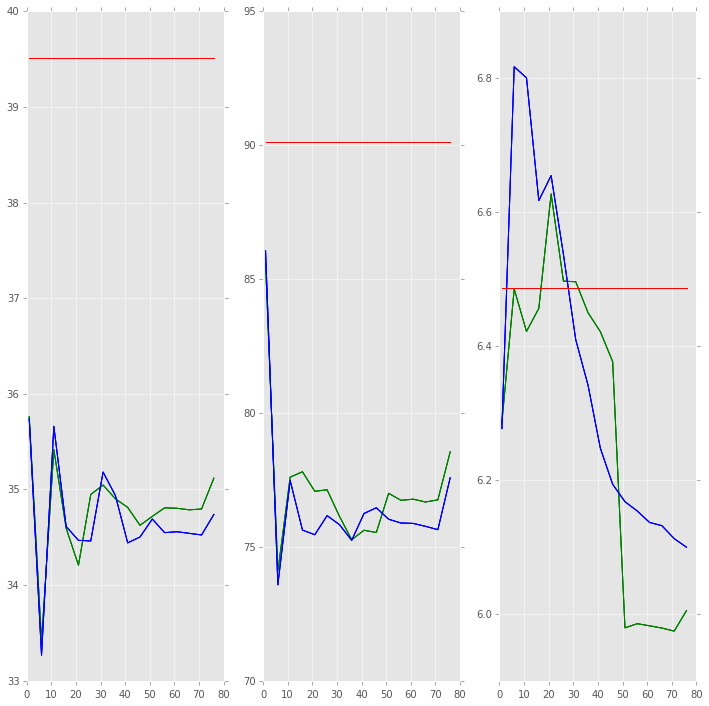

In [195]:
plt.figure(1)
plt.cla()
plt.xscale('log')
plt.yscale('log')
plt.xticks(k_nums, k_nums)
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.plot(k, rss[:,i], 'g', label='logreg')
    plt.plot(k, brss[:, i], 'b', label='bayesian reg')
    plt.plot(k, drss[:, i], 'r', label='dummy reg')


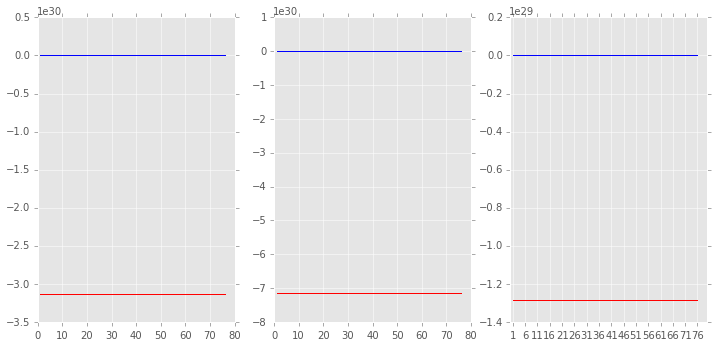

In [186]:
for i in range(3):
    plt.subplot(2, 3, i + 1)
    plt.plot(k, vs[:,i], 'g', label='reg')
    plt.plot(k, bvs[:, i], 'b', label='bayesian reg')
    plt.plot(k, dvs[:, i], 'r', label='dummy reg')
    
plt.xticks(k_nums, k_nums)
plt.show()

In [190]:
print k_nums
print support

[1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75]


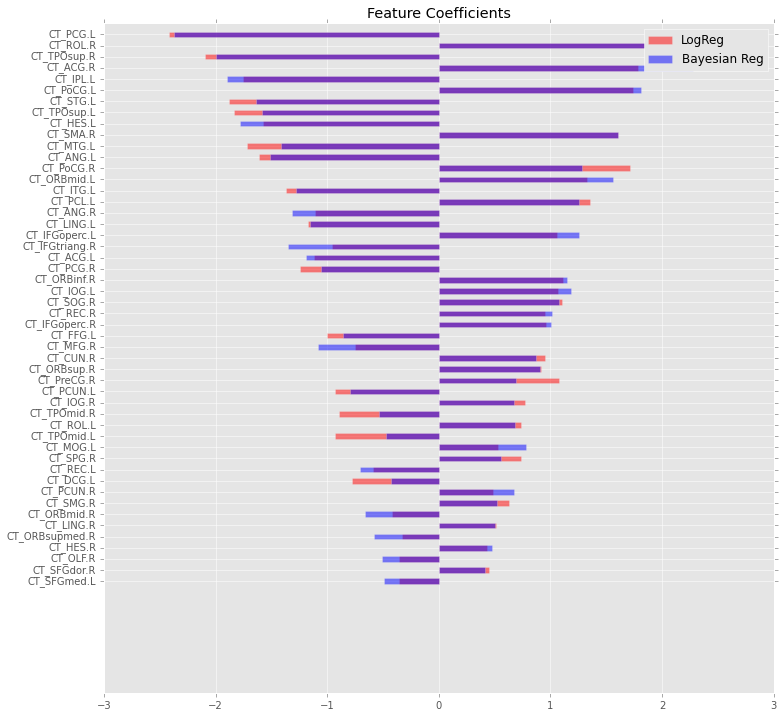

In [199]:
# Pick a classifier, plot the feature weights
K = 76 # K components to visualize
T = 0 # Target clinical scale to visualize
k_ind = k_nums.index(K)
classifiers_pair = k_classifiers[k_ind][T]
c = classifiers_pair[0]     
b = classifiers_pair[1]
log_coefs = scale(c.coef_)
bayes_coefs = scale(b.coef_)
var_names = np.array(var_names)
feats = zip(var_names[support], log_coefs, bayes_coefs)
feats.sort(reverse=False, key=lambda x: abs(x[1]) + abs(x[2]))
feats = feats[-50:]
# Plot the feature importances of the classifier
plt.figure()
plt.title("Feature Coefficients")
y_pos = np.arange(len(feats))
plt.barh(y_pos, width=zip(*feats)[1], height=0.5, color='r', align="center", alpha=0.5, label='LogReg')
plt.barh(y_pos, width=zip(*feats)[2], height=0.5, color='b', align="center", alpha=0.5, label='Bayesian Reg')
plt.yticks(y_pos, zip(*feats)[0])
plt.legend()
plt.show()

In [196]:
sel = k_selectors[k_ind]
classers = k_classifiers[k_ind]
# Show test predictions
preds = np.zeros(shape=(y_t.shape[0],9))
header = []
summary = []
summary_header = []
for i in range(3):
    col = i * 3
    X_t_r = sel[i][0].transform(X_t)
    X_t_rb = sel[i][1].transform(X_t)
    y_t_hat = classers[i][0].predict(X_t_r)
    y_t_hatb = classers[i][1].predict(X_t_rb)
    preds[:,col] = y_t[:,i]
    preds[:,col + 1] = y_t_hat
    preds[:,col + 2] = y_t_hatb
    for t in targets:
        header.append(t)
        header.append('l y_hat')
        header.append('b y_hat')
    summary.extend([
            metrics.mean_squared_error(y_t_hat, y_t[:,i]),
            metrics.mean_squared_error(y_t_hatb, y_t[:,i]),
            metrics.r2_score(y_t_hat, y_t[:,i]),
            metrics.r2_score(y_t_hatb, y_t[:,i]),
        ])

    summary_header.extend(['l MMSE', 'b MMSE', 'l R2', 'b R2'])

print tabulate([summary], summary_header)
print
print tabulate(preds, header)




  l MMSE    b MMSE      l R2      b R2    l MMSE    b MMSE      l R2      b R2    l MMSE    b MMSE      l R2      b R2
--------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------
 34.8362   34.8419  -4.21878  -3.44748   65.5744   65.1603  -3.15221  -2.41402   4.88157   4.88635  -2.88488  -2.40658

  ADAS11_bl    l y_hat    b y_hat    ADAS13_bl    l y_hat    b y_hat    MMSE_bl    l y_hat    b y_hat
-----------  ---------  ---------  -----------  ---------  ---------  ---------  ---------  ---------
      19.33   12.3102    11.9371         30.33    19.0247   18.2394          22    26.2143    26.2338
      16       8.27364    8.10995        26       13.1895   12.8703          26    28.6718    28.8495
      21.67   13.9333    13.7794         33.67    22.1455   21.9136          23    25.4323    25.3344
       6       9.33986    9.38238         8       15.4739   15.9223          30    27.4081    27.2425
       5       9.55367    9.05